In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from scipy.stats import norm
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.cdf import get_cdf, quantile_regression, get_mean_from_nf, compute_marginal, get_cdf_from_nf
from NCP.nn.losses import CMELoss
from NCP.metrics import smooth_cdf
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from scipy.stats import laplace, cauchy, bernoulli, pareto
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from conditionalconformal import CondConf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


import normflows as nf

from NCP.nn.nf_module import NFModule

from NCP.examples.tools.plot_utils import setup_plots, plot_expectation
from NCP.examples.tools.data_gen import gen_additive_noise_data
setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 100

NEXP=1

# Common optimizer
lr = 1e-3

optimizer = Adam
optimizer_kwargs = {
        'lr': lr
        }

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


device = 'cuda' if torch.cuda.is_available() else 'cpu'

symatrised pareto distribution

# Laplace noise

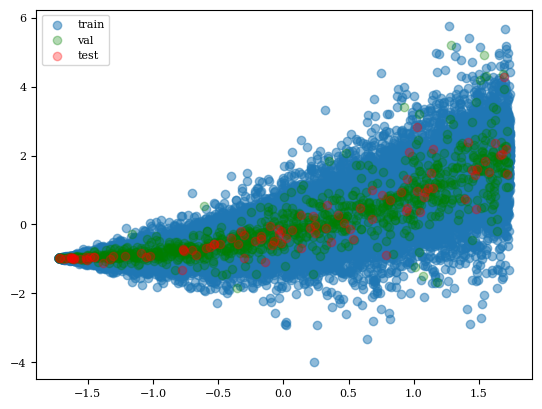

In [3]:
laplace_noise = lambda x : laplace.rvs(loc=0, scale=x)
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_additive_noise_data(laplace_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)
X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)
train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)
#y discretisation for computing cdf
spread = np.max(Y_train) - np.min(Y_train)
p1, p99 = np.min(Y_train), np.max(Y_train)
y_discr, step = np.linspace(p1-0.1*spread, p99+0.1*spread, num=1000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

alpha = 0.1

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 3301: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s, v_num=110, val_loss=-4.50, train_loss=-4.90]   


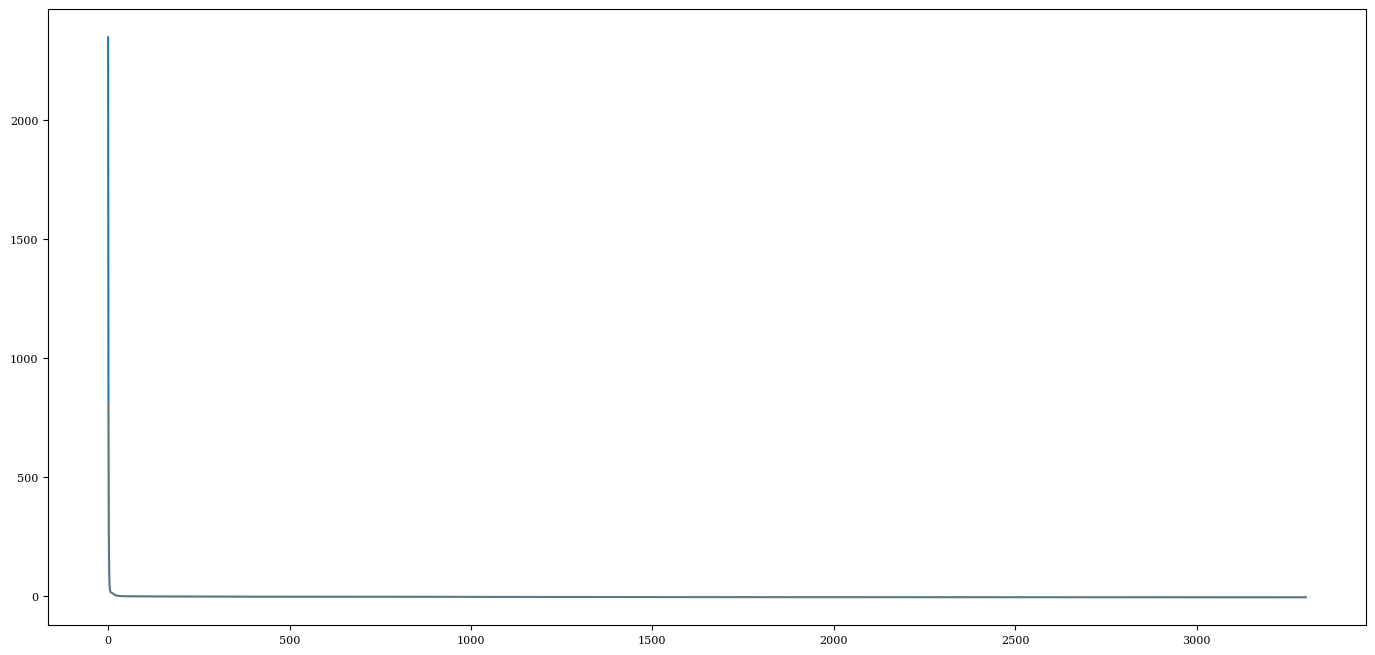

In [4]:
best_models = {}

for exp in range(NEXP):

    L.seed_everything(exp)

    gamma = 1e-3
    epochs = int(5e3)
    output_shape = 500

    MLP_kwargs_U = {
        'input_shape': X_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 2,
        'layer_size':128,
        'dropout': 0.,
        'iterative_whitening': False,
        'activation': torch.nn.GELU
    }

    MLP_kwargs_V = {
        'input_shape': Y_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 2,
        'layer_size':128,
        'dropout': 0,
        'iterative_whitening': False,
        'activation': torch.nn.GELU
    }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'split',
        'gamma': gamma
    }

    reg = NCPOperator(U_operator=MLP, V_operator=MLP, 
                      U_operator_kwargs=MLP_kwargs_U, 
                      V_operator_kwargs=MLP_kwargs_V)

    NCP_module = NCPModule(
        reg,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[early_stop, checkpoint_callback])

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # recover best model during training
    best_model_dict = torch.load(checkpoint_callback.best_model_path)
    restore_buffers_shape(reg, best_model_dict['state_dict'])
    NCP_module.load_state_dict(best_model_dict['state_dict'])
    best_models[exp] = NCP_module.model

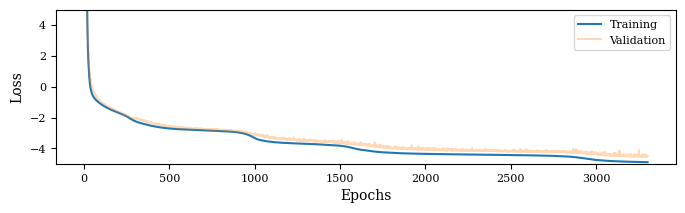

In [17]:
plt.figure(figsize=(8, 2))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.ylim(-5, 5)
plt.savefig('figures/laplace_loss_2.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [5]:
best_models_nf = {}

for exp in range(NEXP):
    L.seed_everything(exp)

    base = nf.distributions.base.DiagGaussian(1)

    # Define list of flows (2 flows to emulate our two MLP approach, each with more capacity than our MLPs)
    num_flows = 2
    latent_size = 1
    hidden_units = 128
    num_blocks = 3
    flows = []
    for i in range(num_flows):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, num_blocks, hidden_units, 
                                                    num_context_channels=X_train.shape[-1])]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # If the target density is not given
    model = nf.ConditionalNormalizingFlow(base, flows)

    nf_module = NFModule(model,
        optimizer,
        optimizer_kwargs)

    checkpoint_callback_vanilla = ModelCheckpoint(monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': int(5e3),
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback_vanilla])

    trainer.fit(nf_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    checkpoint_callback_vanilla.best_model_path
    best_model_dict = torch.load(checkpoint_callback_vanilla.best_model_path)
    nf_module.load_state_dict(best_model_dict['state_dict'])

    best_models_nf[exp] = nf_module.model

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s, v_num=107, val_loss=0.251, train_loss=0.157]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s, v_num=107, val_loss=0.251, train_loss=0.157]


In [6]:
# fit a fourth order polynomial
poly = PolynomialFeatures(4)
linreg = LinearRegression().fit(poly.fit_transform(X_train), Y_train)

# score function is residual
score_fn = lambda x, y : y - linreg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, linreg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [linreg.predict(poly.fit_transform(x)) + s, np.inf]

# intercept only phi_fn
def phi_fn_intercept(x):
    return np.ones((x.shape[0], 1))

phi_fn = phi_fn_intercept
infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}

cond_conf = CondConf(score_fn, phi_fn, infinite_params)
cond_conf.setup_problem(X_val[:200], Y_val[:200])

n_test = len(X_test)

lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))

lbs_r = np.zeros((n_test,))
ubs_r = np.zeros((n_test,))

for i, x_t in enumerate(tqdm(X_test)):
    res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb, exact=False, randomize=True)
    lbs[i] = res[0][0][0]
    res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub, exact=False, randomize=True)
    ubs[i] = res[1][0][0]

100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


In [7]:
# plots with quantiles for one model

pred_test = best_models[0].conditional_expectation(X_test, Y_train, postprocess='whitening').reshape(-1, 1)
nf_pred = np.zeros(X_test.shape[0])
nf_quantiles = np.zeros((X_test.shape[0], 2))
pred_quantiles = np.zeros((X_test.shape[0], 2))
for i, xi in enumerate(tqdm(X_test)):
    nf_pred[i] = get_mean_from_nf(best_models_nf[0], torch.Tensor([xi]), 1000)
    nf_quantiles[i] = quantile_regression(best_models_nf[0], torch.Tensor([xi]),
                                          y_discr_torch, alpha=alpha, 
                                          postprocess='whitening', marginal=marginal, 
                                          model_type='NF')
    pred_quantiles[i] = quantile_regression(best_models[0], torch.Tensor([xi]),
                                            y_discr_torch, alpha = alpha, 
                                            postprocess='whitening', marginal=marginal, 
                                            model_type='NCP')
nf_pred= nf_pred.reshape(-1,1)


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Grégoire\AppData\Local\Temp\ipykernel_4692\1313532481.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  nf_pred[i] = get_mean_from_nf(best_models_nf[0], torch.Tensor([xi]), 1000)
100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


In [8]:
# convolving to estimate on sub intervals:
pred_quantiles
intervsize=0.5
smoothed_quantiles = np.zeros(pred_quantiles.shape)
for i, xi in enumerate(X_test):
    is_in_interv = (X_test[:,0] < xi[0]+intervsize)*(X_test[:,0] > xi[0]-intervsize)
    n_in_interv = is_in_interv.sum()
    is_in_interv = np.tile(is_in_interv, (2,1)).T
    smoothed_quantiles[i] = (pred_quantiles * is_in_interv).sum(axis=0)/n_in_interv

NCP (mse = 0.0083)
NF (mse = 0.035)
Conditional Conformal (mse = 0.0036)


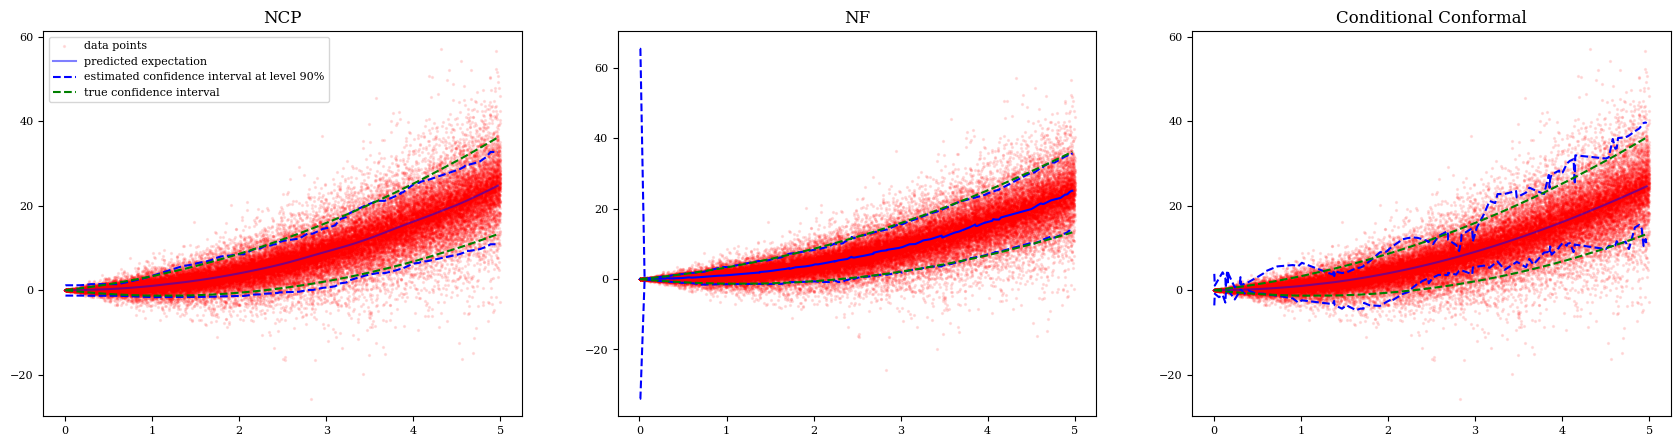

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7,2))
axes = axes.flatten()

Xs_train = xscaler.inverse_transform(X_train)

Xs = xscaler.inverse_transform(X_test)

sorted = np.argsort(Xs.flatten())

true_interv = np.zeros((Xs.shape[0], 2))
for i, xi in enumerate(Xs[sorted]):
    true_interv[i] = np.array(laplace.interval(0.9, loc=xi**2, scale=xi)).flatten()

axes[0].scatter(Xs_train, 
                yscaler.inverse_transform(Y_train), 
                color='r', alpha=0.1, label='data points', s=2)
axes[0].plot(Xs.flatten()[sorted], 
            yscaler.inverse_transform(pred_test).flatten()[sorted], 'b', alpha=0.5, label='predicted expectation')
axes[0].plot(Xs.flatten()[sorted], yscaler.inverse_transform(smoothed_quantiles[:,0].reshape((-1,1))).flatten()[sorted],
             'b', linestyle='dashed', label='estimated confidence interval at level 90%')
axes[0].plot(Xs.flatten()[sorted], yscaler.inverse_transform(smoothed_quantiles[:,1].reshape((-1,1))).flatten()[sorted],
             'b', linestyle='dashed')
# axes[0].plot(Xs.flatten()[sorted], yscaler.inverse_transform(smoothed_quantiles[:,0].reshape((-1,1))).flatten()[sorted],
#              'b', alpha=0.5, linestyle='dashed', label='estimated confidence interval at level 90%')
# axes[0].plot(Xs.flatten()[sorted], yscaler.inverse_transform(smoothed_quantiles[:,1].reshape((-1,1))).flatten()[sorted],
#              'b', alpha=0.5, linestyle='dashed')
axes[0].plot(Xs.flatten()[sorted], true_interv[:,0],
             'g', alpha=1, linestyle='dashed', label='true confidence interval')
axes[0].plot(Xs.flatten()[sorted], true_interv[:,1],
             'g', alpha=1, linestyle='dashed')

axes[0].legend()
axes[0].set_title(f'NCP')
print(f'NCP (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(pred_test)), 4)})')

axes[1].scatter(Xs_train, 
                yscaler.inverse_transform(Y_train), 
                color='r', alpha=0.1, s=2)
axes[1].plot(Xs.flatten()[sorted], 
            yscaler.inverse_transform(nf_pred.reshape((-1,1))).flatten()[sorted], 'b')
axes[1].plot(Xs.flatten()[sorted], yscaler.inverse_transform(nf_quantiles[:,0].reshape((-1,1))).flatten()[sorted],
             'b', linestyle='dashed')
axes[1].plot(Xs.flatten()[sorted], yscaler.inverse_transform(nf_quantiles[:,1].reshape((-1,1))).flatten()[sorted],
             'b', linestyle='dashed')
axes[1].plot(Xs.flatten()[sorted], true_interv[:,0],
             'g', alpha=1, linestyle='dashed', label='true confidence interval')
axes[1].plot(Xs.flatten()[sorted], true_interv[:,1],
             'g', alpha=1, linestyle='dashed')
axes[1].set_title(f'NF')
print(f'NF (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(nf_pred)), 4)})')

axes[2].scatter(Xs_train, 
                yscaler.inverse_transform(Y_train), 
                color='r', alpha=0.1, s=2)
axes[2].plot(Xs.flatten()[sorted], 
            yscaler.inverse_transform(linreg.predict(poly.fit_transform(X_test))).flatten()[sorted], 'b', alpha=0.5)
axes[2].plot(Xs.flatten()[sorted], yscaler.inverse_transform(lbs.reshape((-1,1))).flatten()[sorted],
             'b', alpha=1, linestyle='dashed')
axes[2].plot(Xs.flatten()[sorted], yscaler.inverse_transform(ubs.reshape((-1,1))).flatten()[sorted],
             'b', alpha=1, linestyle='dashed')
axes[2].plot(Xs.flatten()[sorted], true_interv[:,0],
             'g', alpha=1, linestyle='dashed', label='true confidence interval')
axes[2].plot(Xs.flatten()[sorted], true_interv[:,1],
             'g', alpha=1, linestyle='dashed')
axes[2].set_title(f'Conditional Conformal')
print(f'Conditional Conformal (mse = {round(mean_squared_error(Xs**2, yscaler.inverse_transform(linreg.predict(poly.fit_transform(X_test)))), 4)})')
plt.savefig('figures/laplace_means_kernel_3.png', format='png', bbox_inches='tight')

# Cauchy noise

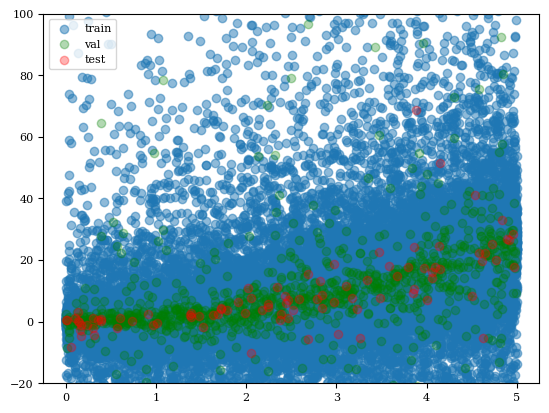

In [24]:
cauchy_noise = lambda x : cauchy.rvs(loc=0, scale=1+x)
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_additive_noise_data(cauchy_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)
X_train, Y_train, X_val, Y_val, X_test, Y_test = xscaler.inverse_transform(X_train), yscaler.inverse_transform(Y_train), xscaler.inverse_transform(X_val), yscaler.inverse_transform(Y_val), xscaler.inverse_transform(X_test), yscaler.inverse_transform(Y_test)
X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)
train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)
#y discretisation for computing cdf (manual due to cauchy being so spread out)
y_discr, step = np.linspace(-50, 100, num=3000, retstep=True)
y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

k_pdf = compute_marginal(bandwidth='scott').fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

alpha = 0.1

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.ylim(-20, 100)
plt.show()

In [12]:
best_models = {}

for exp in range(NEXP):

    L.seed_everything(exp)

    gamma = 1e-3
    epochs = int(5e3)
    output_shape = 500

    MLP_kwargs_U = {
        'input_shape': X_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 5,
        'layer_size': 256,
        'dropout': 0.,
        'iterative_whitening': False,
        'activation': torch.nn.GELU
    }

    MLP_kwargs_V = {
        'input_shape': Y_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 5,
        'layer_size':256,
        'dropout': 0,
        'iterative_whitening': False,
        'activation': torch.nn.GELU
    }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'split',
        'gamma': gamma
    }

    reg = NCPOperator(U_operator=MLP, V_operator=MLP, 
                      U_operator_kwargs=MLP_kwargs_U, 
                      V_operator_kwargs=MLP_kwargs_V)

    NCP_module = NCPModule(
        reg,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=400, mode="min")
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback])

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # recover best model during training
    best_model_dict = torch.load(checkpoint_callback.best_model_path)
    restore_buffers_shape(reg, best_model_dict['state_dict'])
    NCP_module.load_state_dict(best_model_dict['state_dict'])
    best_models[exp] = NCP_module.model

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s, v_num=108, val_loss=31.50, train_loss=22.90]  

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s, v_num=108, val_loss=31.50, train_loss=22.90]


In [13]:
best_models_nf = {}

for exp in range(NEXP):
    L.seed_everything(exp)

    base = nf.distributions.base.DiagGaussian(1)

    # Define list of flows (2 flows to emulate our two MLP approach, each with more capacity than our MLPs)
    num_flows = 2
    latent_size = 1
    hidden_units = 128
    num_blocks = 3
    flows = []
    for i in range(num_flows):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, num_blocks, hidden_units, 
                                                    num_context_channels=X_train.shape[-1])]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # If the target density is not given
    model = nf.ConditionalNormalizingFlow(base, flows)

    nf_module = NFModule(model,
        optimizer,
        optimizer_kwargs)

    checkpoint_callback_vanilla = ModelCheckpoint(monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': int(5e3),
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback_vanilla])

    trainer.fit(nf_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    checkpoint_callback_vanilla.best_model_path
    best_model_dict = torch.load(checkpoint_callback_vanilla.best_model_path)
    nf_module.load_state_dict(best_model_dict['state_dict'])

    best_models_nf[exp] = nf_module.model

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, v_num=109, val_loss=117.0, train_loss=4.88e+3]  

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, v_num=109, val_loss=117.0, train_loss=4.88e+3]


In [14]:
# fit a fourth order polynomial
poly = PolynomialFeatures(4)
lin_reg = LinearRegression().fit(poly.fit_transform(xscaler.transform(X_train)), yscaler.transform(Y_train))

# score function is residual
score_fn = lambda x, y : y - lin_reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, lin_reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [lin_reg.predict(poly.fit_transform(x)) + s, np.inf]

# intercept only phi_fn
def phi_fn_intercept(x):
    return np.ones((x.shape[0], 1))

phi_fn = phi_fn_intercept
infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}

cond_conf = CondConf(score_fn, phi_fn, infinite_params)
cond_conf.setup_problem(xscaler.transform(X_val[:200]), yscaler.transform(Y_val[:200]))

n_test = len(X_test)

lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))

for i, x_t in enumerate(tqdm(xscaler.transform(X_test))):
    res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb, exact=False, randomize=True)
    lbs[i] = res[0][0][0]
    res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub, exact=False, randomize=True)
    ubs[i] = res[1][0][0]

lbs = yscaler.inverse_transform(lbs.reshape(-1, 1))
ubs = yscaler.inverse_transform(ubs.reshape(-1, 1))

100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


In [25]:
# plots with quantiles for one model

nf_quantiles = np.zeros((X_test.shape[0], 2))
pred_quantiles = np.zeros((X_test.shape[0], 2))
for i, xi in enumerate(tqdm(X_test)):
    nf_quantiles[i] = quantile_regression(best_models_nf[0], torch.Tensor(xscaler.transform([xi])),
                                          y_discr_torch, alpha = alpha, 
                                          postprocess='whitening', marginal=marginal, 
                                          model_type='NF')
    pred_quantiles[i] = quantile_regression(best_models[0], torch.Tensor([xi]),
                                            y_discr_torch, alpha = alpha, 
                                            postprocess='whitening', marginal=marginal, 
                                            model_type='NCP')

100%|██████████| 100/100 [08:02<00:00,  4.83s/it]


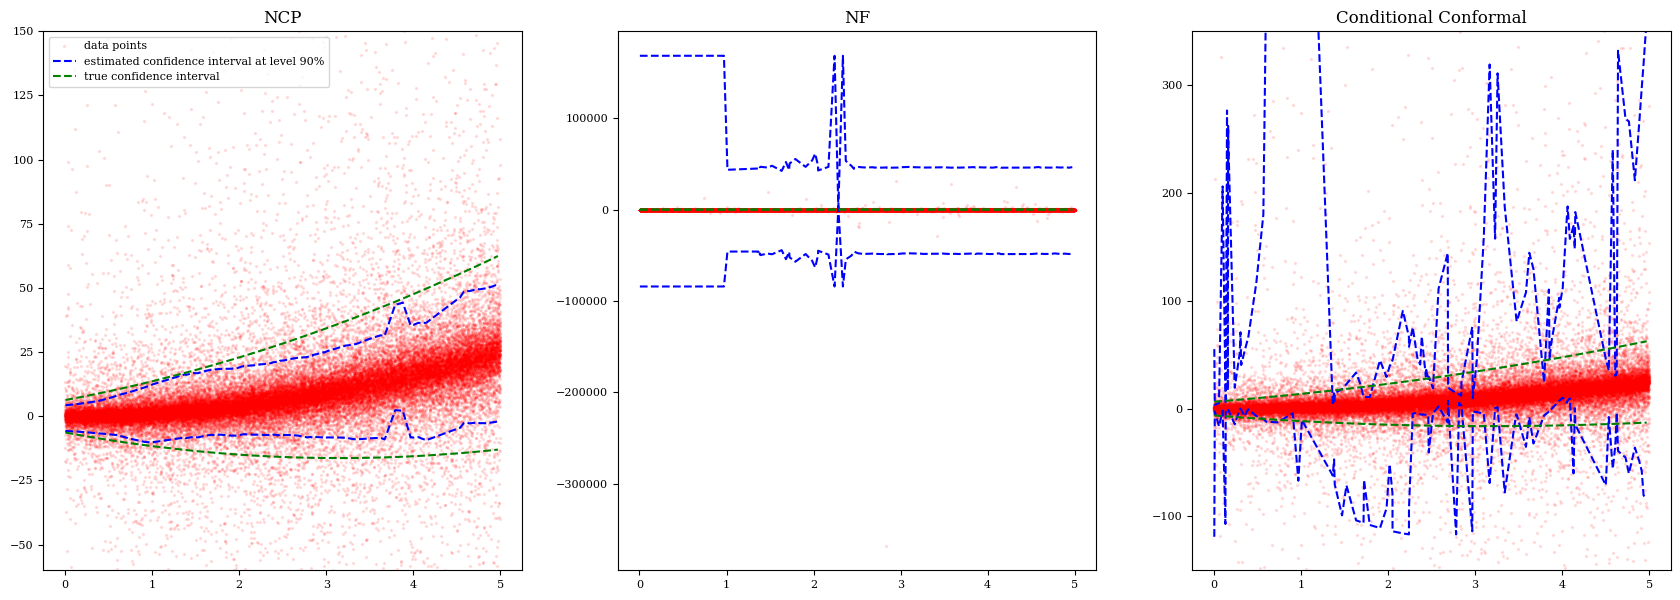

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(7,2))
axes = axes.flatten()

Xs_train = X_train

Xs = X_test

sorted = np.argsort(Xs.flatten())

ymin = -60
ymax=150

true_interv = np.zeros((Xs.shape[0], 2))
for i, xi in enumerate(Xs[sorted]):
    true_interv[i] = np.array(cauchy.interval(0.9, loc=xi**2, scale=1+xi)).flatten()

axes[0].scatter(Xs_train, Y_train, 
                color='r', alpha=0.1, label='data points', s=2)
axes[0].plot(Xs.flatten()[sorted], pred_quantiles[:,0][sorted],
             'b', linestyle='dashed', label='estimated confidence interval at level 90%')
axes[0].plot(Xs.flatten()[sorted], pred_quantiles[:,1][sorted],
             'b', linestyle='dashed')
# axes[0].plot(Xs.flatten()[sorted], yscaler.inverse_transform(smoothed_quantiles[:,0].reshape((-1,1))).flatten()[sorted],
#              'b', alpha=0.5, linestyle='dashed', label='estimated confidence interval at level 90%')
# axes[0].plot(Xs.flatten()[sorted], yscaler.inverse_transform(smoothed_quantiles[:,1].reshape((-1,1))).flatten()[sorted],
#              'b', alpha=0.5, linestyle='dashed')
axes[0].plot(Xs.flatten()[sorted], true_interv[:,0],
             'g', alpha=1, linestyle='dashed', label='true confidence interval')
axes[0].plot(Xs.flatten()[sorted], true_interv[:,1],
             'g', alpha=1, linestyle='dashed')
axes[0].set_ylim(ymin, ymax)

axes[0].legend()
axes[0].set_title(f'NCP')

axes[1].scatter(Xs_train, Y_train, 
                color='r', alpha=0.1, s=2)
axes[1].plot(Xs.flatten()[sorted], yscaler.inverse_transform(nf_quantiles[:,0].reshape((-1,1))).flatten()[sorted],
             'b', linestyle='dashed')
axes[1].plot(Xs.flatten()[sorted], yscaler.inverse_transform(nf_quantiles[:,1].reshape((-1,1))).flatten()[sorted],
             'b', linestyle='dashed')
axes[1].plot(Xs.flatten()[sorted], true_interv[:,0],
             'g', alpha=1, linestyle='dashed', label='true confidence interval')
axes[1].plot(Xs.flatten()[sorted], true_interv[:,1],
             'g', alpha=1, linestyle='dashed')
axes[1].set_title(f'NF')
#axes[1].set_ylim(-400, 1000)

axes[2].scatter(Xs_train, Y_train, 
                color='r', alpha=0.1, s=2)
axes[2].plot(Xs.flatten()[sorted], lbs[sorted],
             'b', alpha=1, linestyle='dashed')
axes[2].plot(Xs.flatten()[sorted], ubs[sorted],
             'b', alpha=1, linestyle='dashed')
axes[2].plot(Xs.flatten()[sorted], true_interv[:,0],
             'g', alpha=1, linestyle='dashed', label='true confidence interval')
axes[2].plot(Xs.flatten()[sorted], true_interv[:,1],
             'g', alpha=1, linestyle='dashed')
axes[2].set_title(f'Conditional Conformal')
axes[2].set_ylim(-150, 350)

plt.savefig('figures/cauchy_means_kernel_better.pdf', format='pdf', bbox_inches='tight')

# Skew normal

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import skewnorm
from NCP.cdf import find_best_quantile

def sigmoid(x):
    return 1 / (1+np.exp(-x))

X = np.random.normal(0, 0.5)
Y = np.zeros(X.shape[0])
for i, xi in enumerate(X):
    loc = 0.1*xi
    scale = 0.5 + 0.1*xi**2
    skew = -4 * (1 - sigmoid(xi))
    Y[i] = skewnorm.rvs(skew, loc=loc, scale=scale)

def get_skewnormal_quantile(x, alpha, y_dicsr):
    quantiles = np.zeros((x.shape[0], 2))
    for i,xi in enumerate(x):
        loc = 0.1*xi
        scale = 0.5 + 0.1*xi**2
        skew = -4 * (1 - sigmoid(xi))
        cdf = skewnorm.cdf(y_discr, skew, loc=loc, scale=scale)  
        quantiles[i] = find_best_quantile(y_discr, cdf, alpha)
    return quantiles

X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

xscaler = StandardScaler()
yscaler = StandardScaler()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=N_test, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=N_val, random_state=0)

X_train = xscaler.fit_transform(X_train)
Y_train = yscaler.fit_transform(Y_train)

X_val = xscaler.transform(X_val)
Y_val = yscaler.transform(Y_val)
X_test = xscaler.transform(X_test)
Y_test = yscaler.transform(Y_test)

In [ ]:
best_models = {}

for exp in range(NEXP):

    L.seed_everything(exp)

    gamma = 1e-3
    epochs = int(5e3)
    output_shape = 500

    MLP_kwargs_U = {
        'input_shape': X_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 2,
        'layer_size':128,
        'dropout': 0.,
        'iterative_whitening': False,
        'activation': torch.nn.GELU
    }

    MLP_kwargs_V = {
        'input_shape': Y_train.shape[-1],
        'output_shape': output_shape,
        'n_hidden': 2,
        'layer_size':128,
        'dropout': 0,
        'iterative_whitening': False,
        'activation': torch.nn.GELU
    }

    loss_fn = CMELoss
    loss_kwargs = {
        'mode': 'split',
        'gamma': gamma
    }

    reg = NCPOperator(U_operator=MLP, V_operator=MLP, 
                      U_operator_kwargs=MLP_kwargs_U, 
                      V_operator_kwargs=MLP_kwargs_V)

    NCP_module = NCPModule(
        reg,
        optimizer,
        optimizer_kwargs,
        CMELoss,
        loss_kwargs
    )

    early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
    checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': epochs,
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[early_stop, checkpoint_callback])

    trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    # recover best model during training
    best_model_dict = torch.load(checkpoint_callback.best_model_path)
    restore_buffers_shape(reg, best_model_dict['state_dict'])
    NCP_module.load_state_dict(best_model_dict['state_dict'])
    best_models[exp] = NCP_module.model

In [ ]:
best_models_nf = {}

for exp in range(NEXP):
    L.seed_everything(exp)

    base = nf.distributions.base.DiagGaussian(1)

    # Define list of flows (2 flows to emulate our two MLP approach, each with more capacity than our MLPs)
    num_flows = 2
    latent_size = 1
    hidden_units = 128
    num_blocks = 3
    flows = []
    for i in range(num_flows):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, num_blocks, hidden_units, 
                                                    num_context_channels=X_train.shape[-1])]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # If the target density is not given
    model = nf.ConditionalNormalizingFlow(base, flows)

    nf_module = NFModule(model,
        optimizer,
        optimizer_kwargs)

    checkpoint_callback_vanilla = ModelCheckpoint(monitor="val_loss", mode="min")

    trainer = L.Trainer(**{
        'accelerator': device,
        'max_epochs': int(5e3),
        'log_every_n_steps': 1,
        'enable_progress_bar': True,
        'devices': 1,
        'enable_checkpointing': True,
        'num_sanity_val_steps': 0,
        'enable_model_summary': False,
        }, callbacks=[checkpoint_callback_vanilla])

    trainer.fit(nf_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

    checkpoint_callback_vanilla.best_model_path
    best_model_dict = torch.load(checkpoint_callback_vanilla.best_model_path)
    nf_module.load_state_dict(best_model_dict['state_dict'])

    best_models_nf[exp] = nf_module.model

In [ ]:
# fit a fourth order polynomial
poly = PolynomialFeatures(4)
lin_reg = LinearRegression().fit(poly.fit_transform(xscaler.transform(X_train)), yscaler.transform(Y_train))

# score function is residual
score_fn = lambda x, y : y - lin_reg.predict(poly.fit_transform(x))
score_inv_fn_ub = lambda s, x : [-np.inf, lin_reg.predict(poly.fit_transform(x)) + s]
score_inv_fn_lb = lambda s, x : [lin_reg.predict(poly.fit_transform(x)) + s, np.inf]

# intercept only phi_fn
def phi_fn_intercept(x):
    return np.ones((x.shape[0], 1))

phi_fn = phi_fn_intercept
infinite_params = {'kernel': 'rbf', 'gamma': 12.5, 'lambda': 0.005}

cond_conf = CondConf(score_fn, phi_fn, infinite_params)
cond_conf.setup_problem(xscaler.transform(X_val[:200]), yscaler.transform(Y_val[:200]))

n_test = len(X_test)

lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))

for i, x_t in enumerate(tqdm(xscaler.transform(X_test))):
    res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb, exact=False, randomize=True)
    lbs[i] = res[0][0][0]
    res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub, exact=False, randomize=True)
    ubs[i] = res[1][0][0]

lbs = yscaler.inverse_transform(lbs.reshape(-1, 1))
ubs = yscaler.inverse_transform(ubs.reshape(-1, 1))

In [ ]:
# plots with quantiles for one model

nf_quantiles = np.zeros((X_test.shape[0], 2))
pred_quantiles = np.zeros((X_test.shape[0], 2))
for i, xi in enumerate(tqdm(X_test)):
    nf_quantiles[i] = quantile_regression(best_models_nf[0], torch.Tensor(xscaler.transform([xi])),
                                          y_discr_torch, alpha = alpha, 
                                          postprocess='whitening', marginal=marginal, 
                                          model_type='NF')
    pred_quantiles[i] = quantile_regression(best_models[0], torch.Tensor([xi]),
                                            y_discr_torch, alpha = alpha, 
                                            postprocess='whitening', marginal=marginal, 
                                            model_type='NCP')
true_quantiles = get_skewnormal_quantile(x_test, alpha, y_discr)

# Pareto noise

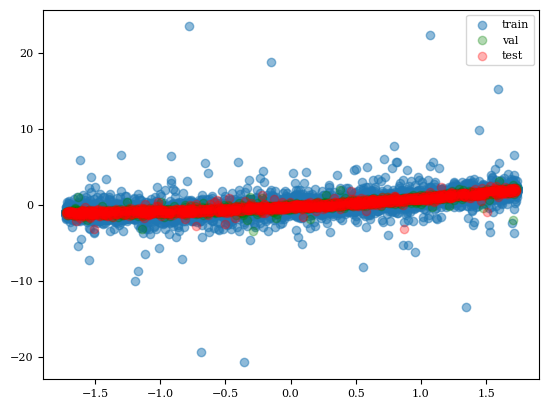

In [31]:
def sym_pareto_cdf(x, scale):
    x_neg = (x<0)
    x_pos = (x>0)
    cdf_x_pos = pareto.cdf(x, scale)
    cdf_x_neg = 1-pareto.cdf(-x, scale)
    return 0.5* cdf_x_neg *  x_neg + (0.5+ 0.5 * cdf_x_pos) *  x_pos

pareto_noise = lambda x : pareto.rvs(2)* (2*bernoulli.rvs(0.5)-1)
X_train, X_test, X_val, Y_val, Y_train, Y_test, xscaler, yscaler = gen_additive_noise_data(pareto_noise, lambda x:x**2, N_train=Ntrain, N_val=Nval, N_test=Ntest)

plt.scatter(X_train, Y_train, alpha=0.5)
plt.scatter(X_val, Y_val, color='green', alpha=0.3)
plt.scatter(X_test, Y_test, color='red', alpha=0.3)
plt.legend(['train', 'val', 'test'])
plt.show()

epoch = 49999, loss = -4.368854522705078: 100%|██████████| 50000/50000 [30:07<00:00, 27.67it/s] 


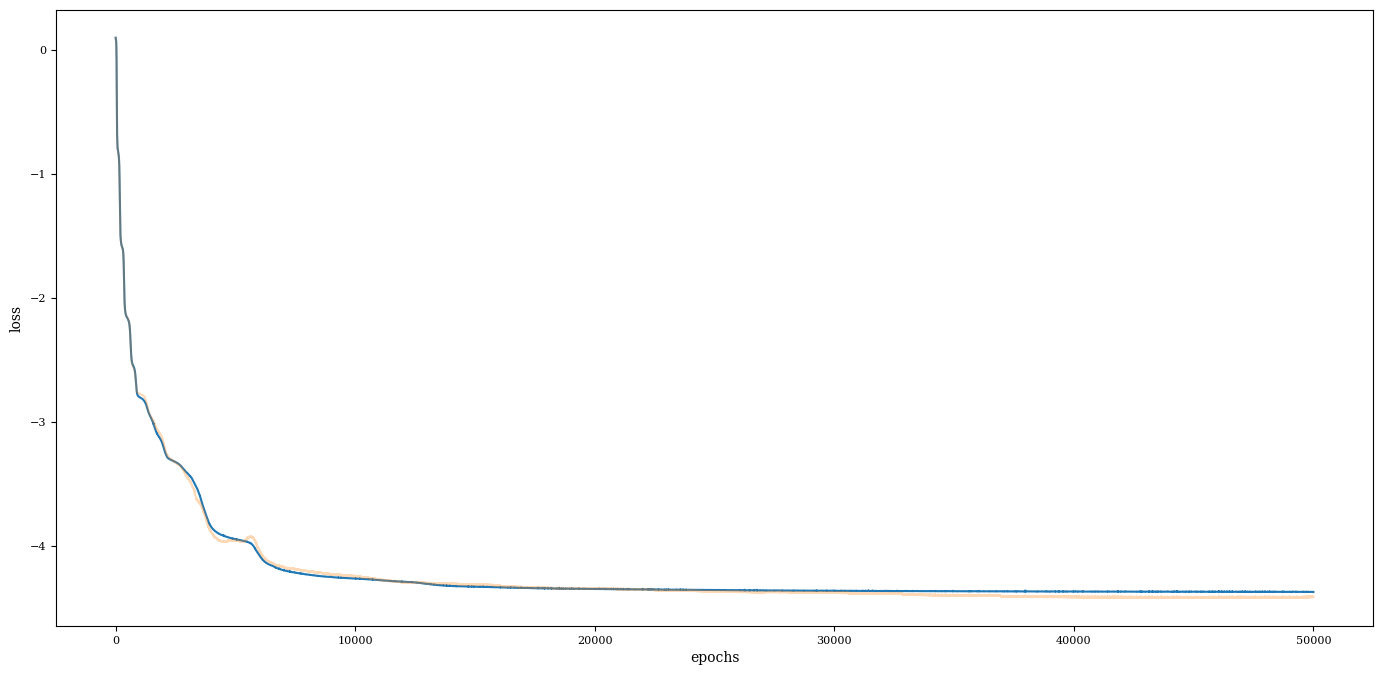

In [28]:

L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e3)

MLP_kwargs = {
    'input_shape': X_train.shape[-1],
    'output_shape': 10,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

pareto_reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs, V_operator_kwargs=MLP_kwargs)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    pareto_reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

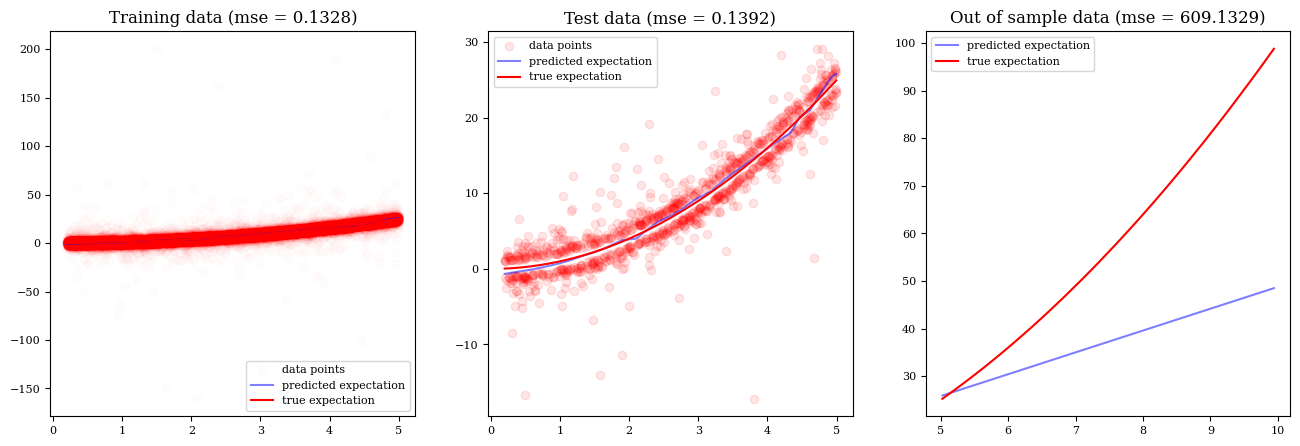

In [29]:
plot_expectation(pareto_reg, X_train, X_test, Y_train, Y_test, xscaler, yscaler)

result for x= 0
- KL: inf
- Hellinger: 0.48825243600600726


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 1
- KL: inf
- Hellinger: 0.4568796621346792


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 3
- KL: inf
- Hellinger: 0.6198143242999391


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


result for x= 4.5
- KL: inf
- Hellinger: 0.7076717248550572


D:\Grégoire\Documents\ncp\NCP\metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_swindow * (np.log(x_swindow)-np.log(y_swindow)))


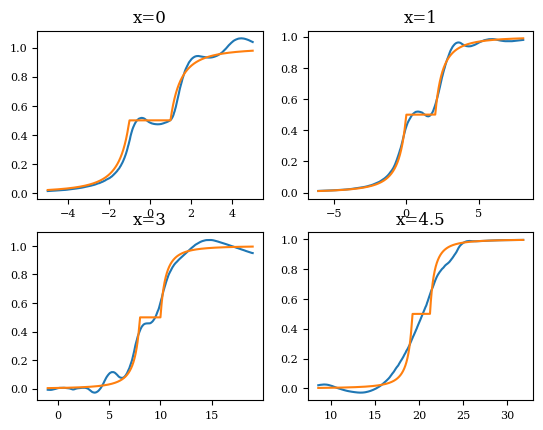

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2)
axes = ax.flatten()

for i, xi in enumerate([0, 1, 3, 4.5]):

    x_scaled = torch.Tensor(xscaler.transform([[xi]]))
    fys, cdf_pred = get_cdf(pareto_reg, x_scaled, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = sym_pareto_cdf(fys-xi**2, 2)

    # normalising the plots for readability:
    if xi <= 5:
        loc = xi**2
        scale = np.sqrt(1+np.abs(xi))
        plt_interv = [loc - 5*scale, loc+5*scale]

        good_fys = ((plt_interv[0] <= fys) & (fys <= plt_interv[1]))

        fys = fys[good_fys]
        cdf_pred = cdf_pred[good_fys]
        true_cdf = true_cdf[good_fys]

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={xi}')
    print('result for x=', xi)
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys, plt_interv)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf)}')
    #print(f'- Wasserstein: {wasserstein1(cdf_pred, true_cdf)}')

plt.show()